device:  cpu
Files already downloaded and verified
Files already downloaded and verified
Current learning rate: 0.0015
Iteration 1 : main_model accuracy on all test data:  0.1043


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

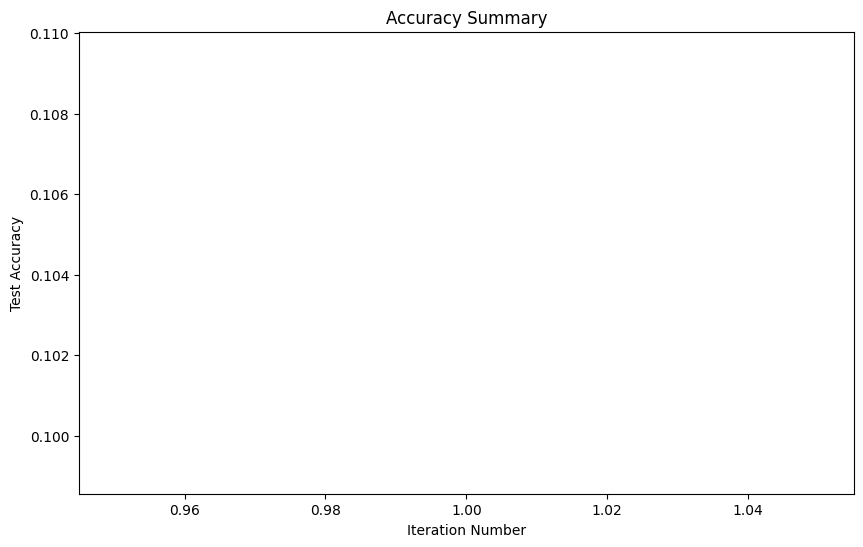

In [4]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt  # Added for plotting
import pandas as pd  # Added for CSV file handling


# Contents of construct_models.py

import torch.nn.functional as F

def weights_init(model, torch_manual_seed=2304):
    torch.manual_seed(torch_manual_seed)
    torch.cuda.manual_seed_all(torch_manual_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

def learning_rate_decay(optimizer_dict, decay_rate):
    for i in range(len(optimizer_dict)):
        optimizer_name = "optimizer" + str(i)
        old_lr = optimizer_dict[optimizer_name].param_groups[0]["lr"]
        optimizer_dict[optimizer_name].param_groups[0]["lr"] = old_lr * decay_rate
    return optimizer_dict

def update_learning_rate_decay(optimizer_dict, new_lr):
    for i in range(len(optimizer_dict)):
        optimizer_name = "optimizer" + str(i)
        optimizer_dict[optimizer_name].param_groups[0]["lr"] = new_lr
    return optimizer_dict

# Model architectures
class Net2nn(nn.Module):
    def __init__(self):
        super(Net2nn, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Netcnn(nn.Module):
    def __init__(self):
        super(Netcnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x



class Netcnn_cifar(nn.Module):
    def __init__(self):
        super(Netcnn_cifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


class Cifar10CNN(nn.Module):

    def __init__(self):
        super(Cifar10CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)


        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)


        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)


        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        # self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)


        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        # x = self.dropout1(x)
        x = self.fc2(x)
        return x


class Net_fashion(nn.Module):
    def __init__(self):
        super(Net_fashion, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


# Contents of train_nodes.py
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import models
from torchvision import transforms
from statistics import NormalDist
from scipy import stats


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        prediction = output.argmax(dim=1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()

    return train_loss / len(train_loader), correct / len(train_loader.dataset)

def train_with_clipping(model, train_loader, criterion, optimizer, device, clipping=True, clipping_threshold=10):
    model.train()
    train_loss = 0.0
    correct = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        if clipping:
            torch.nn.utils.clip_grad_value_(model.parameters(), clipping_threshold)
        optimizer.step()

        train_loss += loss.item()
        prediction = output.argmax(dim=1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()

    return train_loss / len(train_loader), correct / len(train_loader.dataset)


def train_with_augmentation(model, train_loader, criterion, optimizer, device, clipping, clipping_threshold=10, use_augmentation=False, augment=None ):
    model.train()
    train_loss = 0.0
    correct = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        if use_augmentation:
            data = augment(data)

        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        if clipping:
            torch.nn.utils.clip_grad_value_(model.parameters(), clipping_threshold)

        optimizer.step()

        train_loss += loss.item()
        prediction = output.argmax(dim=1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()

    return train_loss / len(train_loader), correct / len(train_loader.dataset)


def validation(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += criterion(output, target).item()
            prediction = output.argmax(dim=1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    correct /= len(test_loader.dataset)

    return (test_loss, correct)


def get_model_names(model_dict):
    name_of_models = list(model_dict.keys())
    return name_of_models


def get_optimizer_names(optimizer_dict):
    name_of_optimizers = list(optimizer_dict.keys())
    return name_of_optimizers


def get_criterion_names(criterion_dict):
    name_of_criterions = list(criterion_dict.keys())
    return name_of_criterions


def get_x_train_sets_names(x_train_dict):
    name_of_x_train_sets = list(x_train_dict.keys())
    return name_of_x_train_sets


def get_y_train_sets_names(y_train_dict):
    name_of_y_train_sets = list(y_train_dict.keys())
    return name_of_y_train_sets


def get_x_valid_sets_names(x_valid_dict):
    name_of_x_valid_sets = list(x_valid_dict.keys())
    return name_of_x_valid_sets


def get_y_valid_sets_names(y_valid_dict):
    name_of_y_valid_sets = list(y_valid_dict.keys())
    return name_of_y_valid_sets


def get_x_test_sets_names(x_test_dict):
    name_of_x_test_sets = list(x_test_dict.keys())
    return name_of_x_test_sets


def get_y_test_sets_names(y_test_dict):
    name_of_y_test_sets = list(y_test_dict.keys())
    return name_of_y_test_sets


def create_model_optimizer_criterion_dict_for_mnist(number_of_samples, learning_rate, momentum, device, is_cnn=False, weight_decay=0):
    model_dict = dict()
    optimizer_dict = dict()
    criterion_dict = dict()

    for i in range(number_of_samples):
        model_name = "model" + str(i)
        if is_cnn:
            model_info = Netcnn()
        else:
            model_info = Net2nn()
        model_info = model_info.to(device)
        model_dict.update({model_name: model_info})

        optimizer_name = "optimizer" + str(i)
        optimizer_info = torch.optim.SGD(model_info.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        optimizer_dict.update({optimizer_name: optimizer_info})

        criterion_name = "criterion" + str(i)
        criterion_info = nn.CrossEntropyLoss()
        criterion_dict.update({criterion_name: criterion_info})

    return model_dict, optimizer_dict, criterion_dict


def create_model_optimizer_criterion_dict_for_cifar_net(number_of_samples, learning_rate, momentum, device,
                                                        weight_decay=0):
    model_dict = dict()
    optimizer_dict = dict()
    criterion_dict = dict()

    for i in range(number_of_samples):
        model_name = "model" + str(i)

        model_info = Netcnn_cifar()

        model_info = model_info.to(device)
        model_dict.update({model_name: model_info})

        optimizer_name = "optimizer" + str(i)
        optimizer_info = torch.optim.SGD(model_info.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        optimizer_dict.update({optimizer_name: optimizer_info})

        criterion_name = "criterion" + str(i)
        criterion_info = nn.CrossEntropyLoss()
        criterion_dict.update({criterion_name: criterion_info})

    return model_dict, optimizer_dict, criterion_dict

def create_model_optimizer_criterion_dict_for_cifar_cnn(number_of_samples, learning_rate, momentum, device,
                                                        weight_decay=0):
    model_dict = dict()
    optimizer_dict = dict()
    criterion_dict = dict()

    for i in range(number_of_samples):
        model_name = "model" + str(i)

        model_info = Cifar10CNN()

        model_info = model_info.to(device)
        model_dict.update({model_name: model_info})

        optimizer_name = "optimizer" + str(i)
        optimizer_info = torch.optim.SGD(model_info.parameters(), lr=learning_rate, momentum=momentum,
                                         weight_decay=weight_decay)
        optimizer_dict.update({optimizer_name: optimizer_info})

        criterion_name = "criterion" + str(i)
        criterion_info = nn.CrossEntropyLoss()
        criterion_dict.update({criterion_name: criterion_info})

    return model_dict, optimizer_dict, criterion_dict

def create_model_optimizer_criterion_dict_for_fashion_mnist(number_of_samples, learning_rate, momentum, device, weight_decay=0):
    model_dict = dict()
    optimizer_dict = dict()
    criterion_dict = dict()

    for i in range(number_of_samples):
        model_name = "model" + str(i)

        model_info = Net_fashion()
        model_info = model_info.to(device)
        model_dict.update({model_name: model_info})

        optimizer_name = "optimizer" + str(i)
        optimizer_info = torch.optim.SGD(model_info.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        optimizer_dict.update({optimizer_name: optimizer_info})

        criterion_name = "criterion" + str(i)
        criterion_info = nn.CrossEntropyLoss()
        criterion_dict.update({criterion_name: criterion_info})

    return model_dict, optimizer_dict, criterion_dict


def create_model_optimizer_criterion_dict_for_cifar_resnet(number_of_samples, learning_rate, momentum, device,
                                                           weight_decay=0):
    model_dict = dict()
    optimizer_dict = dict()
    criterion_dict = dict()

    for i in range(number_of_samples):
        model_name = "model" + str(i)

        model_info = models.resnet18(num_classes=10)

        model_info = model_info.to(device)
        model_dict.update({model_name: model_info})

        optimizer_name = "optimizer" + str(i)
        optimizer_info = torch.optim.SGD(model_info.parameters(), lr=learning_rate, momentum=momentum,
                                         weight_decay=weight_decay)
        optimizer_dict.update({optimizer_name: optimizer_info})

        criterion_name = "criterion" + str(i)
        criterion_info = nn.CrossEntropyLoss()
        criterion_dict.update({criterion_name: criterion_info})

    return model_dict, optimizer_dict, criterion_dict


def send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples):
    name_of_models = list(model_dict.keys())
    main_model_param_data_list = list(main_model.parameters())
    with torch.no_grad():
        for i in range(number_of_samples):
            sample_param_data_list = list(model_dict[name_of_models[i]].parameters())
            for j in range(len(main_model_param_data_list)):
                sample_param_data_list[j].data = main_model_param_data_list[j].data.clone()
    return model_dict


def compare_local_and_merged_model_performance(number_of_samples, x_test_dict, y_test_dict,
                                               batch_size, model_dict, criterion_dict, main_model,
                                               main_criterion, device):
    accuracy_table = pd.DataFrame(data=np.zeros((number_of_samples, 3)),
                                  columns=["sample", "local_ind_model", "merged_main_model"])

    name_of_x_test_sets = list(x_test_dict.keys())
    name_of_y_test_sets = list(y_test_dict.keys())

    name_of_models = list(model_dict.keys())
    name_of_criterions = list(criterion_dict.keys())

    for i in range(number_of_samples):
        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

        model = model_dict[name_of_models[i]]
        criterion = criterion_dict[name_of_criterions[i]]

        individual_loss, individual_accuracy = validation(model, test_dl, criterion, device)
        main_loss, main_accuracy = validation(main_model, test_dl, main_criterion, device)

        accuracy_table.loc[i, "sample"] = "sample " + str(i)
        accuracy_table.loc[i, "local_ind_model"] = individual_accuracy
        accuracy_table.loc[i, "merged_main_model"] = main_accuracy

    return accuracy_table


def start_train_end_node_process_without_print(number_of_samples, x_train_dict, y_train_dict, x_test_dict, y_test_dict,
                                               batch_size, model_dict, criterion_dict, optimizer_dict, numEpoch,
                                               device):
    name_of_x_train_sets = get_x_train_sets_names(x_train_dict)
    name_of_y_train_sets = get_y_train_sets_names(y_train_dict)
    name_of_x_test_sets = get_x_test_sets_names(x_test_dict)
    name_of_y_test_sets = get_y_test_sets_names(y_test_dict)
    name_of_models = get_model_names(model_dict)
    name_of_criterions = get_criterion_names(criterion_dict)
    name_of_optimizers = get_optimizer_names(optimizer_dict)

    for i in range(number_of_samples):

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

        model = model_dict[name_of_models[i]]

        criterion = criterion_dict[name_of_criterions[i]]
        optimizer = optimizer_dict[name_of_optimizers[i]]

        for epoch in range(numEpoch):
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer, device)
            test_loss, test_accuracy = validation(model, test_dl, criterion, device)

def start_train_end_node_process_with_cliiping(number_of_samples, x_train_dict, y_train_dict, x_test_dict, y_test_dict,
                                               batch_size, model_dict, criterion_dict, optimizer_dict, numEpoch,
                                               device, clipping=True, clipping_threshold=10):
    name_of_x_train_sets = get_x_train_sets_names(x_train_dict)
    name_of_y_train_sets = get_y_train_sets_names(y_train_dict)
    name_of_x_test_sets = get_x_test_sets_names(x_test_dict)
    name_of_y_test_sets = get_y_test_sets_names(y_test_dict)
    name_of_models = get_model_names(model_dict)
    name_of_criterions = get_criterion_names(criterion_dict)
    name_of_optimizers = get_optimizer_names(optimizer_dict)

    for i in range(number_of_samples):

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

        model = model_dict[name_of_models[i]]

        criterion = criterion_dict[name_of_criterions[i]]
        optimizer = optimizer_dict[name_of_optimizers[i]]

        for epoch in range(numEpoch):
            train_loss, train_accuracy = train_with_clipping(model, train_dl, criterion, optimizer, device, clipping, clipping_threshold)

            test_loss, test_accuracy = validation(model, test_dl, criterion, device)



def start_train_end_node_process_cifar(number_of_samples, x_train_dict, y_train_dict, x_test_dict, y_test_dict,
                                       batch_size, model_dict, criterion_dict, optimizer_dict, numEpoch,
                                       device,clipping=False, clipping_threshold =10):
    name_of_x_train_sets = get_x_train_sets_names(x_train_dict)
    name_of_y_train_sets = get_y_train_sets_names(y_train_dict)
    name_of_x_test_sets = get_x_test_sets_names(x_test_dict)
    name_of_y_test_sets = get_y_test_sets_names(y_test_dict)
    name_of_models = get_model_names(model_dict)
    name_of_criterions = get_criterion_names(criterion_dict)
    name_of_optimizers = get_optimizer_names(optimizer_dict)

    transform_augment = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop((32, 32), padding=4)])

    for i in range(number_of_samples):

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

        model = model_dict[name_of_models[i]]
        criterion = criterion_dict[name_of_criterions[i]]
        optimizer = optimizer_dict[name_of_optimizers[i]]

        for epoch in range(numEpoch):
            train_loss, train_accuracy = train_with_augmentation(model, train_dl, criterion, optimizer, device,
                                                                 clipping=clipping,
                                                                 clipping_threshold=clipping_threshold,
                                                                 use_augmentation=True, augment=transform_augment)

            test_loss, test_accuracy = validation(model, test_dl, criterion, device)


##########################################

def start_train_end_node_process_byzantine_for_cifar_with_augmentation(number_of_samples, x_train_dict, y_train_dict, x_test_dict, y_test_dict,
                                               batch_size, model_dict, criterion_dict, optimizer_dict, numEpoch, byzantine_node_list,
                                            byzantine_mean, byzantine_std, device, clipping=False, clipping_threshold =10, iteration_byzantine_seed=None ):

    name_of_x_train_sets = get_x_train_sets_names(x_train_dict)
    name_of_y_train_sets = get_y_train_sets_names(y_train_dict)
    name_of_x_test_sets = get_x_test_sets_names(x_test_dict)
    name_of_y_test_sets = get_y_test_sets_names(y_test_dict)
    name_of_models = get_model_names(model_dict)
    name_of_criterions = get_criterion_names(criterion_dict)
    name_of_optimizers = get_optimizer_names(optimizer_dict)

    transform_augment = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop((32, 32), padding=4)])



    trusted_nodes=  np.array(list(set(np.arange(number_of_samples)) - set(byzantine_node_list)), dtype=int)

    ## STANDARD LOCAL MODEL TRAİNİNG PROCESS FOR TRUSTED NODES
    for i in trusted_nodes:

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

        model = model_dict[name_of_models[i]]
        criterion = criterion_dict[name_of_criterions[i]]
        optimizer = optimizer_dict[name_of_optimizers[i]]

        for epoch in range(numEpoch):
            train_loss, train_accuracy = train_with_augmentation(model, train_dl, criterion, optimizer, device, clipping=clipping, clipping_threshold=clipping_threshold,
                                                                 use_augmentation=True, augment=transform_augment)
            test_loss, test_accuracy = validation(model, test_dl, criterion, device)

    with torch.no_grad():

        for j in byzantine_node_list:

            hostile_node_param_data_list = list(model_dict[name_of_models[j]].parameters())

            for k in range(len(hostile_node_param_data_list)):
                np.random.seed(iteration_byzantine_seed)
                hostile_node_param_data_list[k].data = torch.tensor(np.random.normal(byzantine_mean,byzantine_std, hostile_node_param_data_list[k].data.shape ), dtype=torch.float32, device=device)

            model_dict[name_of_models[j]].float()


###############################################

def start_train_end_node_process_byzantine(number_of_samples, x_train_dict, y_train_dict, x_test_dict, y_test_dict,
                                               batch_size, model_dict, criterion_dict, optimizer_dict,
                                               numEpoch, byzantine_node_list, byzantine_mean, byzantine_std, device, iteration_byzantine_seed=None ):
    name_of_x_train_sets = get_x_train_sets_names(x_train_dict)
    name_of_y_train_sets = get_y_train_sets_names(y_train_dict)
    name_of_x_test_sets = get_x_test_sets_names(x_test_dict)
    name_of_y_test_sets = get_y_test_sets_names(y_test_dict)
    name_of_models = get_model_names(model_dict)
    name_of_criterions = get_criterion_names(criterion_dict)
    name_of_optimizers = get_optimizer_names(optimizer_dict)



    trusted_nodes=  np.array(list(set(np.arange(number_of_samples)) - set(byzantine_node_list)), dtype=int)

    ## STANDARD LOCAL MODEL TRAİNİNG PROCESS FOR TRUSTED NODES
    for i in trusted_nodes:

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

        model = model_dict[name_of_models[i]]
        criterion = criterion_dict[name_of_criterions[i]]
        optimizer = optimizer_dict[name_of_optimizers[i]]

        for epoch in range(numEpoch):
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer, device)
            test_loss, test_accuracy = validation(model, test_dl, criterion, device)


    with torch.no_grad():
        for j in byzantine_node_list:
            hostile_node_param_data_list = list(model_dict[name_of_models[j]].parameters())

            for k in range(len(hostile_node_param_data_list)):
                np.random.seed(iteration_byzantine_seed)
                hostile_node_param_data_list[k].data = torch.tensor(np.random.normal(byzantine_mean,byzantine_std, hostile_node_param_data_list[k].data.shape ), dtype=torch.float32, device=device)

            model_dict[name_of_models[j]].float()


################################################

def calculate_euclidean_distances(main_model, model_dict):
    calculated_parameter_names = []

    for parameters in main_model.named_parameters():  ## bias dataları için distance hesaplamıyorum
        if "bias" not in parameters[0]:
            calculated_parameter_names.append(parameters[0])

    columns = ["model"] + calculated_parameter_names
    distances = pd.DataFrame(columns=columns)
    model_names = list(model_dict.keys())

    main_model_weight_dict = {}
    for parameter in main_model.named_parameters():
        name = parameter[0]
        weight_info = parameter[1]
        main_model_weight_dict.update({name: weight_info})

    with torch.no_grad():
        for i in range(len(model_names)):
            distances.loc[i, "model"] = model_names[i]
            sample_node_parameter_list = list(model_dict[model_names[i]].named_parameters())
            for j in sample_node_parameter_list:
                if j[0] in calculated_parameter_names:
                    distances.loc[i, j[0]] = round(
                        np.linalg.norm(main_model_weight_dict[j[0]].cpu().data - j[1].cpu().data), 4)

    return distances


def calculate_lower_and_upper_limit(data, factor):
    quantiles = data.quantile(q=[0.25, 0.50, 0.75]).values
    q1 = quantiles[0]
    q2 = quantiles[1]
    q3 = quantiles[2]
    iqr = q3 - q1
    lower_limit = q1 - factor * iqr
    upper_limit = q3 + factor * iqr
    return lower_limit, upper_limit


def get_outlier_situation_and_thresholds_for_layers(distances, factor=1.5):
    layers = list(distances.columns)
    layers.remove("model")
    threshold_columns = []
    for layer in layers:
        threshold_columns.append((layer + "_lower"))
        threshold_columns.append((layer + "_upper"))
    thresholds = pd.DataFrame(columns=threshold_columns)

    include_calculation_result = True
    for layer in layers:
        data = distances[layer]
        lower, upper = calculate_lower_and_upper_limit(data, factor)
        lower_name = layer + "_lower"
        upper_name = layer + "_upper"
        thresholds.loc[0, lower_name] = lower
        thresholds.loc[0, upper_name] = upper
        name = layer + "_is_in_ci"

        distances[name] = (distances[layer] > lower) & (distances[layer] < upper)
        include_calculation_result = include_calculation_result & distances[name]

    distances["include_calculation"] = include_calculation_result
    return distances, thresholds


def compare_individual_models_on_only_one_label(model_dict, criterion_dict, x_just_dict, y_just_dict, batch_size,
                                                device):
    columns = ["model_name"]
    label_names = []
    for l in range(10):
        label_names.append("label" + str(l))
        columns.append("label" + str(l))

    accuracy_rec = pd.DataFrame(data=np.zeros([10, 11]), columns=columns)

    # x_just_dict, y_just_dict = create_just_data(x_test, y_test, x_just_name="x_test_just_", y_just_name="y_test_just_")

    name_of_x_test_just_sets = list(x_just_dict.keys())
    name_of_y_test_just_sets = list(y_just_dict.keys())
    name_of_models = list(model_dict.keys())
    name_of_criterions = list(criterion_dict.keys())

    for i in range(len(name_of_models)):
        model = model_dict[name_of_models[i]]
        criterion = criterion_dict[name_of_criterions[i]]

        accuracy_rec.loc[i, "model_name"] = name_of_models[i]

        for j in range(10):
            x_test_just = x_just_dict[name_of_x_test_just_sets[j]]
            y_test_just = y_just_dict[name_of_y_test_just_sets[j]]

            test_ds_just = TensorDataset(x_test_just, y_test_just)
            test_dl_just = DataLoader(test_ds_just, batch_size=batch_size * 2)

            test_loss, test_accuracy = validation(model, test_dl_just, criterion, device)

            accuracy_rec.loc[i, label_names[j]] = test_accuracy
    #             print( name_of_models[i], ">>" ,j, " tahmin etmesi: {:7.4f}".format(test_accuracy))
    #         print("******************")
    return accuracy_rec


def get_averaged_weights_faster(model_dict, device):
    name_of_models = list(model_dict.keys())
    parameters = list(model_dict[name_of_models[0]].named_parameters())
    ##named_parameters layer adını ve datayı tuple olarak dönderiyor
    ##parameters sadece datayı dönderiyor

    weight_dict = dict()
    for k in range(len(parameters)):
        name = parameters[k][0]
        w_shape = list(parameters[k][1].shape)
        w_shape.insert(0, len(model_dict))
        weight_info = torch.zeros(w_shape, device=device)
        weight_dict.update({name: weight_info})

    weight_names_list = list(weight_dict.keys())
    with torch.no_grad():
        for i in range(len(model_dict)):
            sample_param_data_list = list(model_dict[name_of_models[i]].parameters())
            for j in range(len(weight_names_list)):
                weight_dict[weight_names_list[j]][i,] = sample_param_data_list[j].data.clone()

        mean_weight_array = []
        for m in range(len(weight_names_list)):
            mean_weight_array.append(torch.mean(weight_dict[weight_names_list[m]], 0))

    return mean_weight_array


def set_averaged_weights_as_main_model_weights_and_update_main_model(main_model, model_dict, device):
    mean_weight_array = get_averaged_weights_faster(model_dict, device)
    main_model_param_data_list = list(main_model.parameters())
    with torch.no_grad():
        for j in range(len(main_model_param_data_list)):
            main_model_param_data_list[j].data = mean_weight_array[j]
    return main_model


def get_coordinate_wise_median_of_weights(model_dict, device):
    name_of_models = list(model_dict.keys())
    parameters = list(model_dict[name_of_models[0]].named_parameters())
    ##named_parameters layer adını ve datayı tuple olarak dönderiyor
    ##parameters sadece datayı dönderiyor

    weight_dict = dict()
    for k in range(len(parameters)):
        name = parameters[k][0]
        w_shape = list(parameters[k][1].shape)
        w_shape.insert(0, len(model_dict))
        weight_info = torch.zeros(w_shape, device=device)
        weight_dict.update({name: weight_info})

    weight_names_list = list(weight_dict.keys())
    with torch.no_grad():
        for i in range(len(model_dict)):
            sample_param_data_list = list(model_dict[name_of_models[i]].parameters())
            for j in range(len(weight_names_list)):
                weight_dict[weight_names_list[j]][i,] = sample_param_data_list[j].data.clone()

        median_weight_array = []
        for m in range(len(weight_names_list)):
            median_weight_array.append(torch.median(weight_dict[weight_names_list[m]], 0).values)

    return median_weight_array

def set_coordinatewise_med_weights_as_main_model_weights_and_update_main_model(main_model, model_dict, device):
    median_weight_array = get_coordinate_wise_median_of_weights(model_dict, device)
    main_model_param_data_list = list(main_model.parameters())
    with torch.no_grad():
        for j in range(len(main_model_param_data_list)):
            main_model_param_data_list[j].data = median_weight_array[j]
    return main_model








def get_averaged_weights_without_outliers_strict_condition(model_dict, iteration_distance, device):
    chosen_clients = iteration_distance[iteration_distance["include_calculation"] == True].index
    name_of_models = list(model_dict.keys())
    parameters = list(model_dict[name_of_models[0]].named_parameters())

    ### mesela conv 1 için zeros [chosen client kadar, 32, 1, 5, 5] atanıyor bunları doldurup mean alacağız
    weight_dict = dict()
    for k in range(len(parameters)):
        name = parameters[k][0]
        w_shape = list(parameters[k][1].shape)
        w_shape.insert(0, len(chosen_clients))
        weight_info = torch.zeros(w_shape, device=device)
        weight_dict.update({name: weight_info})

    weight_names_list = list(weight_dict.keys())
    with torch.no_grad():
        for i in range(len(chosen_clients)):
            sample_param_data_list = list(model_dict[name_of_models[chosen_clients[i]]].parameters())
            for j in range(len(weight_names_list)):
                weight_dict[weight_names_list[j]][i,] = sample_param_data_list[j].data.clone()

        mean_weight_array = []
        for m in range(len(weight_names_list)):
            mean_weight_array.append(torch.mean(weight_dict[weight_names_list[m]], 0))

    return mean_weight_array


def strict_condition_without_outliers_set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,
                                                                                                       model_dict,
                                                                                                       iteration_distance,
                                                                                                       device):
    mean_weight_array = get_averaged_weights_without_outliers_strict_condition(model_dict, iteration_distance, device)
    main_model_param_data_list = list(main_model.parameters())
    with torch.no_grad():
        for j in range(len(main_model_param_data_list)):
            main_model_param_data_list[j].data = mean_weight_array[j]
    return main_model

## they do not perform any training and send same parameters that are received at the beginning at the fl round
def start_train_end_node_process_with_anticatalysts(number_of_samples, x_train_dict, y_train_dict, x_test_dict, y_test_dict,
                                                    batch_size, model_dict, criterion_dict, optimizer_dict,
                                                    numEpoch, byzantine_node_list, device):
    name_of_x_train_sets = get_x_train_sets_names(x_train_dict)
    name_of_y_train_sets = get_y_train_sets_names(y_train_dict)
    name_of_x_test_sets = get_x_test_sets_names(x_test_dict)
    name_of_y_test_sets = get_y_test_sets_names(y_test_dict)
    name_of_models = get_model_names(model_dict)
    name_of_criterions = get_criterion_names(criterion_dict)
    name_of_optimizers = get_optimizer_names(optimizer_dict)



    trusted_nodes=  np.array(list(set(np.arange(number_of_samples)) - set(byzantine_node_list)), dtype=int)

    ## STANDARD LOCAL MODEL TRAİNİNG PROCESS FOR TRUSTED NODES
    for i in trusted_nodes:

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

        model = model_dict[name_of_models[i]]
        criterion = criterion_dict[name_of_criterions[i]]
        optimizer = optimizer_dict[name_of_optimizers[i]]

        for epoch in range(numEpoch):
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer, device)
            test_loss, test_accuracy = validation(model, test_dl, criterion, device)


######################################
#### a little is enough functions
def get_zscore_for_a_little_is_enough (number_of_samples,hostile_node_percentage):
#     from statistics import NormalDist is defined at the top
    malicious = int(number_of_samples * hostile_node_percentage)
    supporter = np.floor((number_of_samples / 2) + 1) - malicious
    area = (number_of_samples - malicious - supporter) / (number_of_samples - malicious)
    zscore = NormalDist().inv_cdf(area)
    return zscore
def get_byzantine_node_stats_for_a_little(model_dict,byzantine_node_list, device):
    name_of_models = []
    for node in byzantine_node_list:
        name_of_models.append("model"+str(node))
    parameters = list(model_dict[name_of_models[0]].named_parameters())
    ##named_parameters layer adını ve datayı tuple olarak dönderiyor
    ##parameters sadece datayı dönderiyor
    weight_dict = dict()
    for k in range(len(parameters)):
        name = parameters[k][0]
        w_shape = list(parameters[k][1].shape)
        w_shape.insert(0, len(byzantine_node_list))
        weight_info = torch.zeros(w_shape, device=device)
        weight_dict.update({name: weight_info})
    weight_names_list = list(weight_dict.keys())
    with torch.no_grad():
        for i in range(len(byzantine_node_list)):
            sample_param_data_list = list(model_dict[name_of_models[i]].parameters())
            for j in range(len(weight_names_list)):
                weight_dict[weight_names_list[j]][i,] = sample_param_data_list[j].data.clone()
        mean_weight_array = []
        std_weight_array = []
        for m in range(len(weight_names_list)):
            mean_weight_array.append(torch.mean(weight_dict[weight_names_list[m]], 0))
            std_weight_array.append(torch.std(weight_dict[weight_names_list[m]], 0))
    return mean_weight_array,std_weight_array
def change_parameters_of_hostile_nodes(model_dict, byzantine_node_list,zscore, device):
    name_of_models = list(model_dict.keys())
    with torch.no_grad():
        mean_weight_array,std_weight_array = get_byzantine_node_stats_for_a_little(model_dict,byzantine_node_list, device=device)
        for j in byzantine_node_list:
            hostile_node_param_data_list = list(model_dict[name_of_models[j]].parameters())
            for k in range(len(hostile_node_param_data_list)):
                hostile_node_param_data_list[k].data= mean_weight_array[k]-std_weight_array[k]*zscore
            model_dict[name_of_models[j]].float()
    return model_dict
#####################################
def get_trimmed_mean(model_dict, hostile_node_percentage, device):
    name_of_models = list(model_dict.keys())
    parameters = list(model_dict[name_of_models[0]].named_parameters())
    weight_dict = dict()
    for k in range(len(parameters)):
        name = parameters[k][0]
        w_shape = list(parameters[k][1].shape)
        w_shape.insert(0, len(model_dict))
        weight_info = torch.zeros(w_shape, device=device)
        weight_dict.update({name: weight_info})
    weight_names_list = list(weight_dict.keys())
    with torch.no_grad():
        for i in range(len(model_dict)):
            sample_param_data_list = list(model_dict[name_of_models[i]].parameters())
            for j in range(len(weight_names_list)):
                weight_dict[weight_names_list[j]][i,] = sample_param_data_list[j].data.clone()
    mean_weight_array = []
    for m in range(len(weight_names_list)):
        layers_from_nodes = weight_dict[weight_names_list[m]]
        trim_layer_info=stats.trim_mean(layers_from_nodes.clone().cpu(), hostile_node_percentage, axis=0)
        mean_weight_array.append(trim_layer_info)
    return mean_weight_array
def set_trimmed_mean_weights_as_main_model_weights_and_update_main_model(main_model, model_dict, hostile_node_percentage, device):
    mean_weight_array = get_trimmed_mean(model_dict, hostile_node_percentage, device)
    main_model_param_data_list = list(main_model.parameters())
    with torch.no_grad():
        for j in range(len(main_model_param_data_list)):
                        main_model_param_data_list[j].data = torch.tensor(mean_weight_array[j], dtype=torch.float32, device=device)
    return main_model
######################################
# fang partial knowledge attack adaptation
def partial_knowledge_fang_ind(main_model, model_dict,byzantine_node_list, iteration_byzantine_seed, device):
    name_of_models = list(model_dict.keys())
    with torch.no_grad():
        mean_weight_array, std_weight_array = get_byzantine_node_stats_for_a_little(model_dict, byzantine_node_list,
                                                                                       device=device)
        main_model_param_data_list = list(main_model.parameters())
        for j in byzantine_node_list:
            hostile_node_param_data_list = list(model_dict[name_of_models[j]].parameters())
            for k in range(len(hostile_node_param_data_list)):
                original_shape = list(hostile_node_param_data_list[k].data.shape)
                data = np.zeros(original_shape)
                hostile_data = hostile_node_param_data_list[k].data.clone().data.cpu()
                main_model_data = main_model_param_data_list[k].data.clone().data.cpu()
                mean = mean_weight_array[k].clone().data.cpu()
                std = std_weight_array[k].clone().data.cpu()
                sign_matrix = (hostile_data > main_model_data)
                np.random.seed(iteration_byzantine_seed) ## nodelar kendi mean stdlerine göre alıyor her experimentin x. roundı aynı gibi
                data[sign_matrix == True] = np.random.uniform(
                    low=mean[sign_matrix == True] - 4 * std[sign_matrix == True],
                    high=mean[sign_matrix == True] - 3 * std[sign_matrix == True])
                np.random.seed(iteration_byzantine_seed)
                data[sign_matrix == False] = np.random.uniform(
                    low=mean[sign_matrix == False] + 3 * std[sign_matrix == False],
                    high=mean[sign_matrix == False] + 4 * std[sign_matrix == False])
                hostile_node_param_data_list[k].data = torch.tensor(data,dtype=torch.float32, device=device)
            model_dict[name_of_models[j]].float()
    return model_dict
def partial_knowledge_fang_org(main_model, model_dict, byzantine_node_list, iteration_byzantine_seed, device):
    name_of_models = list(model_dict.keys())
    with torch.no_grad():
        mean_weight_array, std_weight_array = get_byzantine_node_stats_for_a_little(model_dict, byzantine_node_list,
                                                                                       device=device)
        main_model_param_data_list = list(main_model.parameters())
        organized = []
        for k in range(len(main_model_param_data_list)):
            original_shape = list(main_model_param_data_list[k].data.shape)
            data = np.zeros(original_shape)
            main_model_data = main_model_param_data_list[k].clone().data.cpu()
            mean = mean_weight_array[k].clone().data.cpu()
            std = std_weight_array[k].clone().data.cpu()
            sign_matrix = (mean > main_model_data)
            np.random.seed(iteration_byzantine_seed)
            data[sign_matrix == True] = np.random.uniform(
                low=mean[sign_matrix == True] - 4 * std[sign_matrix == True],
                high=mean[sign_matrix == True] - 3 * std[sign_matrix == True])
            np.random.seed(iteration_byzantine_seed)
            data[sign_matrix == False] = np.random.uniform(
                low=mean[sign_matrix == False] + 3 * std[sign_matrix == False],
                high=mean[sign_matrix == False] + 4 * std[sign_matrix == False])
            organized.append(data)
    for b in byzantine_node_list:
        hostile_node_param_data_list = list(model_dict[name_of_models[b]].parameters())
        for m in range(len(hostile_node_param_data_list)):
            hostile_node_param_data_list[m].data = torch.tensor(organized[m], dtype=torch.float32, device=device)
        model_dict[name_of_models[b]].float()
    return model_dict

# Contents of distribute_data.py
import numpy as np
import pandas as pd
import torch
import cv2
import os
import requests
import pickle
import gzip
import math
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


def load_mnist_data():
    DATA_PATH = Path("data")
    PATH = DATA_PATH / "mnist"

    PATH.mkdir(parents=True, exist_ok=True)

    URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
    FILENAME = "mnist.pkl.gz"

    if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

    with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding="latin-1")

    return x_train, y_train, x_valid, y_valid, x_test, y_test


def load_cifar_data():
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

    x_train = torch.zeros((50000, 3, 32, 32))
    y_train = torch.zeros(50000)
    ind_train = 0
    for data, output in trainset:
        x_train[ind_train, :, :, :] = data
        y_train[ind_train] = output
        ind_train = ind_train + 1

    x_test = torch.zeros((10000, 3, 32, 32))
    y_test = torch.zeros(10000)
    ind_test = 0
    for data, output in testset:
        x_test[ind_test, :, :, :] = data
        y_test[ind_test] = output
        ind_test = ind_test + 1

    y_train = y_train.type(torch.LongTensor)
    y_test = y_test.type(torch.LongTensor)

    return x_train, y_train, x_test, y_test



def show_grid_cifar(x_data,y_data, row,column):
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    fig, axes = plt.subplots(row,column,figsize=(8,8))
    for i in range(row):
        for j in range(column):
            num_index = np.random.randint(len(x_data))
            img=x_data[num_index,:,:,:]
            img = img / 2 + 0.5     # unnormalize
            npimg = img.numpy()
            npimg =np.transpose(npimg, (1, 2, 0))
            axes[i,j].imshow(npimg)

            axes[i,j].axis("off")
            axes[i,j].set_title(classes[int(y_data[num_index])])
    plt.show()

def load_fashion_mnist_data():
    transform = transforms.Compose([transforms.ToTensor()])

    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    x_train = trainset.data
    x_train = x_train / 255
    y_train = trainset.targets

    x_test = testset.data
    x_test = x_test / 255
    y_test = testset.targets

    return x_train, y_train, x_test, y_test


def show_grid_fashion_mnist(x_data, y_data, row, column):
    classes = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
    fig, axes = plt.subplots(row, column, figsize=(8, 8))
    for i in range(row):
        for j in range(column):
            num_index = np.random.randint(len(x_data))

            axes[i, j].imshow(x_data[num_index], cmap="gray")
            axes[i, j].axis("off")
            axes[i, j].set_title(classes[int(y_data[num_index])])
    plt.show()


def split_and_shuffle_labels(y_data, seed, amount):
    y_data = pd.DataFrame(y_data, columns=["labels"])
    y_data["i"] = np.arange(len(y_data))
    label_dict = dict()
    for i in range(10):
        var_name = "label" + str(i)
        label_info = y_data[y_data["labels"] == i]
        np.random.seed(seed)
        label_info = np.random.permutation(label_info)
        label_info = label_info[0:amount]
        label_info = pd.DataFrame(label_info, columns=["labels", "i"])
        label_dict.update({var_name: label_info})
    return label_dict



def get_info_for_distribute_non_iid_with_different_n_and_amount(number_of_samples, n, amount, seed, min_n_each_node=2):
    node_label_info = np.ones([number_of_samples, n]) * -1
    columns = []
    for j in range(n):
        columns.append("s" + str(j))
    node_label_info = pd.DataFrame(node_label_info, columns=columns, dtype=int)

    np.random.seed(seed)
    seeds = np.random.choice(number_of_samples * n * 5, size=number_of_samples, replace=False)
    for i in range(number_of_samples):
        np.random.seed(seeds[i])
        how_many_label_created = np.random.randint(
            n + 1 - min_n_each_node) + min_n_each_node  ## ensures at least one label is created by default
        which_labels = np.random.choice(10, size=how_many_label_created, replace=False)
        node_label_info.iloc[i, 0:len(which_labels)] = which_labels

    #################################
    #################################

    total_label_occurences = pd.DataFrame()
    for m in range(10):

        total_label_occurences.loc[0, m] = int(np.sum(node_label_info.values == m))
        if total_label_occurences.loc[0, m] == 0:
            total_label_occurences.loc[1, m] = 0
        else:
            total_label_occurences.loc[1, m] = int(amount / np.sum(node_label_info.values == m))
    total_label_occurences = total_label_occurences.astype('int32')

    ##################################
    ##################################

    amount_info_table = pd.DataFrame(np.zeros([number_of_samples, n]), dtype=int)
    for a in range(number_of_samples):
        for b in range(n):
            if node_label_info.iloc[a, b] == -1:
                amount_info_table.iloc[a, b] = 0
            else:
                amount_info_table.iloc[a, b] = total_label_occurences.iloc[1, node_label_info.iloc[a, b]]

    return node_label_info, total_label_occurences, amount_info_table


def distribute_mnist_data_to_participants(label_dict, amount, number_of_samples, n,
                                          x_data, y_data, x_name, y_name, node_label_info,
                                          amount_info_table, is_cnn=False):
    label_names = list(label_dict)
    label_dict_data = pd.DataFrame(columns=["labels", "i"])

    for a in label_names:
        data = pd.DataFrame.from_dict(label_dict[a])
        label_dict_data = pd.concat([label_dict_data, data], ignore_index=True)

    index_counter = pd.DataFrame(label_names, columns=["labels"])
    index_counter["start"] = np.ones(10, dtype=int) * np.arange(10) * amount
    index_counter["end"] = np.ones(10, dtype=int) * np.arange(10) * amount

    x_data_dict = dict()
    y_data_dict = dict()

    for i in range(number_of_samples):
        node_data_indices = pd.DataFrame()

        xname = x_name + str(i)
        yname = y_name + str(i)

        for j in range(n):
            label = node_label_info.iloc[i, j]
            if label != -1:
                label_amount = amount_info_table.iloc[i, j]
                index_counter.loc[label, "end"] = index_counter.loc[label, "end"] + label_amount
                node_data_indices = pd.concat([node_data_indices, label_dict_data.loc[
                                                                  index_counter.loc[label, "start"]:index_counter.loc[
                                                                                                        label, "end"] - 1,
                                                                  "i"]])
                index_counter.loc[label, "start"] = index_counter.loc[label, "end"]

        x_info = x_data[node_data_indices.iloc[:, 0].reset_index(drop=True), :]
        if is_cnn:
            reshape_size = int(np.sqrt(x_info.shape[1]))
            x_info = x_info.view(-1, 1, reshape_size, reshape_size)

        x_data_dict.update({xname: x_info})

        y_info = y_data[node_data_indices.iloc[:, 0].reset_index(drop=True)]
        y_data_dict.update({yname: y_info})

    return x_data_dict, y_data_dict


def distribute_fashion_data_to_participants(label_dict, amount, number_of_samples, n,
                                            x_data, y_data, x_name, y_name, node_label_info, amount_info_table):
    label_names = list(label_dict)
    label_dict_data = pd.DataFrame(columns=["labels", "i"])

    for a in label_names:
        data = pd.DataFrame.from_dict(label_dict[a])
        label_dict_data = pd.concat([label_dict_data, data], ignore_index=True)

    index_counter = pd.DataFrame(label_names, columns=["labels"])
    index_counter["start"] = np.ones(10, dtype=int) * np.arange(10) * amount
    index_counter["end"] = np.ones(10, dtype=int) * np.arange(10) * amount

    x_data_dict = dict()
    y_data_dict = dict()

    for i in range(number_of_samples):
        node_data_indices = pd.DataFrame()

        xname = x_name + str(i)
        yname = y_name + str(i)

        for j in range(n):
            label = node_label_info.iloc[i, j]
            if label != -1:
                label_amount = amount_info_table.iloc[i, j]
                index_counter.loc[label, "end"] = index_counter.loc[label, "end"] + label_amount
                node_data_indices = pd.concat([node_data_indices, label_dict_data.loc[
                                                                  index_counter.loc[label, "start"]:index_counter.loc[
                                                                                                        label, "end"] - 1,
                                                                  "i"]])
                #                 print(label, ", start:", index_counter.loc[label,"start"], ", end:", index_counter.loc[label,"end"] )
                index_counter.loc[label, "start"] = index_counter.loc[label, "end"]

        x_info = x_data[node_data_indices.iloc[:, 0].reset_index(drop=True), :]

        x_info = x_info.view(-1, 1, 28, 28)
        x_data_dict.update({xname: x_info})

        y_info = y_data[node_data_indices.iloc[:, 0].reset_index(drop=True)]
        y_data_dict.update({yname: y_info})

    return x_data_dict, y_data_dict


def distribute_cifar_data_to_participants(label_dict, amount, number_of_samples, n,
                                          x_data, y_data, x_name, y_name, node_label_info,
                                          amount_info_table):
    label_names = list(label_dict)
    label_dict_data = pd.DataFrame(columns=["labels", "i"])

    for a in label_names:
        data = pd.DataFrame.from_dict(label_dict[a])
        label_dict_data = pd.concat([label_dict_data, data], ignore_index=True)

    index_counter = pd.DataFrame(label_names, columns=["labels"])
    index_counter["start"] = np.ones(10, dtype=int) * np.arange(10) * amount
    index_counter["end"] = np.ones(10, dtype=int) * np.arange(10) * amount

    x_data_dict = dict()
    y_data_dict = dict()

    for i in range(number_of_samples):
        node_data_indices = pd.DataFrame()

        xname = x_name + str(i)
        yname = y_name + str(i)

        for j in range(n):
            label = node_label_info.iloc[i, j]
            if label != -1:
                label_amount = amount_info_table.iloc[i, j]
                index_counter.loc[label, "end"] = index_counter.loc[label, "end"] + label_amount
                node_data_indices = pd.concat([node_data_indices, label_dict_data.loc[
                                                                  index_counter.loc[label, "start"]:index_counter.loc[
                                                                                                        label, "end"] - 1,
                                                                  "i"]])

                index_counter.loc[label, "start"] = index_counter.loc[label, "end"]

        x_info = x_data[node_data_indices.iloc[:, 0].reset_index(drop=True), :]

        x_data_dict.update({xname: x_info})

        y_info = y_data[node_data_indices.iloc[:, 0].reset_index(drop=True)]
        y_data_dict.update({yname: y_info})

    return x_data_dict, y_data_dict


def create_just_data(x_data, y_data, x_just_name, y_just_name):
    x_just_dict = dict()
    y_just_dict = dict()

    for i in range(10):
        xname = x_just_name + str(i)
        x_info = x_data[y_data == i]
        x_just_dict.update({xname: x_info})

        yname = y_just_name + str(i)
        y_info = y_data[y_data == i]
        y_just_dict.update({yname: y_info})

    return x_just_dict, y_just_dict


def get_equal_size_test_data_from_each_label(x_test, y_test, min_amount=890):
    y_test_eq=pd.DataFrame(y_test, columns=["labels"])
    y_test_eq["ind"]=np.arange(len(y_test))
    hold=pd.DataFrame(columns=["labels", "ind"])
    for i in range(10):
        hold=pd.concat([hold,y_test_eq[y_test_eq["labels"]==i].iloc[0:min_amount,:] ])
    indices=np.array(hold["ind"], dtype=int)
    x_test=x_test[indices, :]
    y_test=y_test[indices]
    return x_test, y_test


def choose_nodes_randomly_to_convert_hostile(hostile_node_percentage, number_of_samples, hostility_seed=90):
    nodes_list=[]
    np.random.seed(hostility_seed)
    nodes=np.random.choice(number_of_samples, size=int(number_of_samples*hostile_node_percentage), replace=False)
    for node in nodes:
        name="y_train"+str(node)
        nodes_list.append(name)
    return nodes_list

def convert_nodes_to_hostile(y_dict, nodes_list,
                             converter_dict={0:9,1:7, 2:5,3:8, 4:6, 5:2, 6:4, 7:1, 8:3, 9:0}):
    for node in nodes_list:
        original_data=y_dict[node]
        converted_data=np.ones(y_dict[node].shape, dtype=int)*-1
        labels_in_node=np.unique(original_data)
        for label in labels_in_node:
            converted_data[original_data==label]=converter_dict[label]
        converted_data=(torch.tensor(converted_data)).type(torch.LongTensor)
        y_dict.update({node:converted_data})
    return y_dict



def create_different_converters_for_each_attacker(y_dict, nodes_list, converters_seed):
    converters = dict()
    np.random.seed(converters_seed)
    converter_seeds_array = np.random.choice(5000, size=len(nodes_list), replace=False)

    for i in range(len(nodes_list)):
        unique_labels = np.unique(y_dict[nodes_list[i]])
        np.random.seed([converter_seeds_array[i]])
        subseeds = np.random.choice(1000, len(unique_labels), replace=False)

        conv = dict()
        for j in range(len(unique_labels)):
            choose_from = np.delete(np.arange(10), unique_labels[j])
            np.random.seed(subseeds[j])
            chosen = np.random.choice(choose_from, replace=False)
            conv[unique_labels[j]] = chosen
        converters.update({nodes_list[i]: conv})
    return converters

def convert_nodes_to_hostile_with_different_converters(y_dict, nodes_list, converters_seed=61):
    converters= create_different_converters_for_each_attacker(y_dict, nodes_list, converters_seed)
    y_dict_converted = y_dict.copy()
    for node in nodes_list:
        original_data=y_dict[node]
        converted_data=np.ones(y_dict[node].shape, dtype=int)*-1
        labels_in_node=np.unique(original_data)
        for label in labels_in_node:
            converted_data[original_data==label]=converters[node][label]
        converted_data=(torch.tensor(converted_data)).type(torch.LongTensor)
        y_dict_converted.update({node:converted_data})
    return y_dict_converted


def get_byzantine_node_list(hostile_node_percentage, number_of_samples, hostility_seed=90):

    np.random.seed(hostility_seed)
    nodes=np.random.choice(number_of_samples, size=int(number_of_samples*hostile_node_percentage), replace=False)
    return nodes

#main script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

number_of_samples = 100 #number of participants

is_noniid = True
if is_noniid:
    n = 5
    min_n_each_node = 5
else:
    n = 10
    min_n_each_node = 10

is_organized = True
hostile_node_percentage = 0.20 #malicious participant ratio
byzantine_mean = 0
byzantine_std = 1

iteration_num = 1 #number of communication rounds(changed 500 to 4)
learning_rate = 0.0015
min_lr = 0.000010
lr_scheduler_factor = 0.2
best_threshold = 0.0001
clipping = True
clipping_threshold = 10

weight_decay = 0.0001
numEpoch = 5 #changed 10 to 5
batch_size = 100
momentum = 0.9

seed = 7
use_seed = 17
hostility_seed = 33
converters_seed = 221
byzantine_seed = 96
factor = 1.5

train_amount = 500 #changed 5000 to 500
test_amount = 1000

x_train, y_train, x_test, y_test = load_cifar_data()

##train
label_dict_train = split_and_shuffle_labels(y_data=y_train, seed=seed, amount=train_amount)
node_label_info_train, total_label_occurences_train, amount_info_table_train = get_info_for_distribute_non_iid_with_different_n_and_amount(
    number_of_samples=number_of_samples, n=n, amount=train_amount, seed=use_seed, min_n_each_node=min_n_each_node)

x_train_dict, y_train_dict = distribute_cifar_data_to_participants(label_dict=label_dict_train,
                                                                      amount=train_amount,
                                                                      number_of_samples=number_of_samples,
                                                                      n=n, x_data=x_train,
                                                                      y_data=y_train,
                                                                      node_label_info=node_label_info_train,
                                                                      amount_info_table=amount_info_table_train,
                                                                      x_name="x_train",
                                                                      y_name="y_train")

## test
label_dict_test = split_and_shuffle_labels(y_data=y_test, seed=seed, amount=test_amount)
node_label_info_test, total_label_occurences_test, amount_info_table_test = get_info_for_distribute_non_iid_with_different_n_and_amount(
    number_of_samples=number_of_samples,
    n=n, amount=test_amount, seed=use_seed, min_n_each_node=min_n_each_node)
x_test_dict, y_test_dict = distribute_cifar_data_to_participants(label_dict=label_dict_test,
                                                                    amount=test_amount,
                                                                    number_of_samples=number_of_samples,
                                                                    n=n, x_data=x_test,
                                                                    y_data=y_test,
                                                                    node_label_info=node_label_info_test,
                                                                    amount_info_table=amount_info_table_test,
                                                                    x_name="x_test",
                                                                    y_name="y_test")

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

main_model = Cifar10CNN()
weights_init(main_model)
main_model = main_model.to(device)

main_optimizer = torch.optim.SGD(main_model.parameters(), lr=learning_rate, momentum=momentum,
                                 weight_decay=weight_decay)
main_criterion = nn.CrossEntropyLoss()


#changed this one to remove verbose=true error
scheduler = lr_scheduler.ReduceLROnPlateau(main_optimizer, mode="max", factor=lr_scheduler_factor,
                                           patience=10, threshold=best_threshold, min_lr=min_lr)
#scheduler = lr_scheduler.ReduceLROnPlateau(main_optimizer, mode="max", factor=lr_scheduler_factor,
                                           #patience=10, threshold=best_threshold, verbose=True, min_lr=min_lr)

model_dict, optimizer_dict, criterion_dict = create_model_optimizer_criterion_dict_for_cifar_cnn(number_of_samples,
                                                                                                    learning_rate,
                                                                                                    momentum, device,
                                                                                                    weight_decay)

test_accuracies_of_each_iteration = np.array([], dtype=float)
# Create a list to store the iteration numbers
iteration_numbers = []  # Added for plotting and CSV file

byzantine_node_list = get_byzantine_node_list(hostile_node_percentage, number_of_samples, hostility_seed)
np.random.seed(byzantine_seed)
byzantine_seeds_array = np.random.choice(5000, size=iteration_num, replace=False)

for iteration in range(iteration_num):
    iteration_numbers.append(iteration + 1)  # Added for plotting and CSV file

    model_dict = send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples)

    if is_organized:
        iteration_byzantine_seed = byzantine_seeds_array[iteration]
    else:
        iteration_byzantine_seed = None

    start_train_end_node_process_byzantine_for_cifar_with_augmentation(number_of_samples, x_train_dict, y_train_dict,
                                                                          x_test_dict, y_test_dict,
                                                                          batch_size, model_dict, criterion_dict,
                                                                          optimizer_dict,
                                                                          numEpoch, byzantine_node_list, byzantine_mean,
                                                                          byzantine_std,
                                                                          device, clipping, clipping_threshold,
                                                                          iteration_byzantine_seed)

    main_model = set_coordinatewise_med_weights_as_main_model_weights_and_update_main_model(main_model, model_dict, device)
    test_loss, test_accuracy = validation(main_model, test_dl, main_criterion, device)
    scheduler.step(test_accuracy)
    new_lr = main_optimizer.param_groups[0]["lr"]
    print(f"Current learning rate: {new_lr}") #added this line
    optimizer_dict = update_learning_rate_decay(optimizer_dict, new_lr)

    test_accuracies_of_each_iteration = np.append(test_accuracies_of_each_iteration, test_accuracy)
    print("Iteration", str(iteration + 1), ": main_model accuracy on all test data: {:7.4f}".format(test_accuracy))

# Save the results to a CSV file
results_df = pd.DataFrame({'Iteration': iteration_numbers, 'Test Accuracy': test_accuracies_of_each_iteration})  # Added for CSV file
results_df.to_csv('results.csv', index=False)  # Added for CSV file

# Plot the graph
plt.figure(figsize=(10, 6))  # Added for plotting
plt.plot(iteration_numbers, test_accuracies_of_each_iteration)  # Added for plotting
plt.title('Accuracy Summary')
plt.xlabel('Iteration Number')
plt.ylabel('Test Accuracy')
plt